In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import LogisticRegression
#from sklearn.model_selection import cross_val_score

#import matplotlib as mpl

from imblearn.over_sampling import SMOTE

from __future__ import division
from collections import Counter

In [2]:
#Pour la font

#mpl.rcParams['font.size'] = 40.0

In [3]:
#Importer la frame

path = '../data/merge.csv'
df = pd.read_csv(path, index_col=0)

In [4]:
#Traiter la frame : Corse unifiee pour plus de simplicité
df.dep = df.dep.apply(lambda x: x.replace('2A', '20').replace('2B', '20'))

#ligne à supprimer
df = df[df.l_EG != 198.67]

In [5]:
groups = ['EG', 'G', 'autre', 'C', 'D', 'ED']
lgroups = ['l_%s' % group for group in groups]
pgroups = ['presid_%s' % group for group in groups]

In [6]:
#stocker le groupe "gagnant" des législatives
df['l_win'] = df[lgroups].idxmax(axis=1)

<h2>Variables de synthèse</h2>
Pour indiquer Paris, sa banlieue, et l'outre-mer. On ne peut pas garder toutes les valeurs de la variable dep donc on se contentera de quelques variables binaires pour indiquer ces 3 situations particulières.

In [7]:
df['surb'] = df.dep.apply(lambda x: 1 if x in [str(i) for i in range(92, 95)] else 0)
df['paris'] = df.dep.apply(lambda x: 1 if x == '75' else 0)

df['OM'] = df.dep.apply(lambda x: 1 if x in [str(i) for i in range(971, 977)] else 0)

In [8]:
df.head()

,dep,circ,year,pop,dens,age_1,age_2,age_3,age_4,etud,...,l_C,l_D,l_ED,l_EG,l_G,l_autre,l_win,surb,paris,OM
0,1,1.0,1993.0,488244.0,85.0,29.0,30.0,24.0,18.0,0.64,...,0.00,46.47,10.28,19.15,24.11,0.0,l_D,0,0,0
1,1,2.0,1993.0,488244.0,85.0,29.0,30.0,24.0,18.0,0.64,...,0.00,46.53,18.79,20.73,13.95,0.0,l_D,0,0,0
2,1,3.0,1993.0,488244.0,85.0,29.0,30.0,24.0,18.0,0.64,...,51.59,0.00,12.41,18.83,17.18,0.0,l_C,0,0,0
3,1,4.0,1993.0,488244.0,85.0,29.0,30.0,24.0,18.0,0.64,...,48.86,0.00,17.46,17.72,15.95,0.0,l_C,0,0,0
4,2,1.0,1993.0,538219.0,73.0,29.0,29.0,22.0,19.0,0.93,...,0.00,42.65,12.33,21.31,23.70,0.0,l_D,0,0,0


In [9]:
df.columns

Index([u'dep', u'circ', u'year', u'pop', u'dens', u'age_1', u'age_2', u'age_3',
       u'age_4', u'etud', u'hf', u'chom', u'presid_C', u'presid_D',
       u'presid_ED', u'presid_EG', u'presid_G', u'presid_autre', u'l_C',
       u'l_D', u'l_ED', u'l_EG', u'l_G', u'l_autre', u'l_win', u'surb',
       u'paris', u'OM'],
      dtype='object')

<h2>SMOTE</h2>
Pour rééquilibrer les classes dans le jeu d'entraînement, on synthétise des lignes de classe  EG, C et ED avec la lib imblearn. On rééquilibre de sorte qu'aucune classe n'ait son effectif en dessous de 20% de celui de la classe dominante (D). Càd que chaque classe doit atteindre au moin 20% de 993 en effectifs = 199

Note : on exclue les années 93 et 97, pour lesquelles les législatives ne surviennent pas directement après les présidentielles

In [10]:
#Effectif de chaque classe dans le jeu d'entraînement sans avoir rééquilibré
df[(2000 < df.year) & (df.year < 2017)].l_win.value_counts()

l_D     993
l_G     520
l_EG    112
l_C      63
l_ED     11
Name: l_win, dtype: int64

<h2>Fonction de prédiction</h2>

In [49]:
RF = RandomForestClassifier(n_estimators=100)

#quelles que soient les colonnes choisies comme input, l'output d'entrainement sera toujours :
y0 = df[(2000 < df.year) & (df.year < 2017)]['l_win']

#quelles que soient les colonnes choisies comme input, ce qu'on cherche a predire pour 2017 :
real = df[df.year == 2017].l_win

def predict(xcols, sm):
    '''La fonction produit 10 predictions a partir du random forest avec 100 arbres. Les predictions etant
    instables, on calculera ensuite la moyenne du nombre de circonscriptions "remportees" par chaque groupe.
    
    L\'argument xcols donne les colonnes a utiliser comme variable d\'entrainement.
    L\'argument sm donne le SMOTE a utiliser, i.e le nombre de lignes a generer pour chaque classe.'''
    
    #stockage de l'input d'entraînement
    X0 = df[(2000 < df.year) & (df.year < 2017)][xcols]
    
    #synthèse des lignes de rééquilibrage. On utilisera donc Xres et yres en réalité pour l'entraînement
    Xres, yres = sm.fit_sample(X0, y0)
    
    #input de test pour prédire les législatives de 2017
    test = df[df.year == 2017][xcols]
    
    #results stocke les predictions brutes
    results = []

    #10 prédictions
    for i in range(10):
        RF.fit(Xres, yres)
        p_rf = RF.predict(test)
        results.append(p_rf)
    
    #precision stocke le nombre de circonscriptions prédites "justement" pour chaque prédiction
    precision = [Counter(real.values == r) for r in results]
    
    #count_results stocke le nombre de circonscriptions "remportees" par chaque groupe politique dans chaque prediction
    count_results = [Counter(r) for r in results]
    
    #pmeans calcule une moyenne
    pmeans = {False: np.mean([p[False] for p in precision]),
             True: np.mean([p[True] for p in precision])}
    
    #cmeans calcule une moyenne par groupe des count_results
    cmeans = {lgroup: np.mean([c[lgroup] for c in count_results]) for lgroup in lgroups}
    
    return results, precision, count_results, pmeans, cmeans

<h1> Essai 1 :</h1>
On garde uniquement les variables de synthèse et les scores de présidentielle comme variables d'entrée.

In [50]:
xcols = ['surb', 'paris', 'OM'] + pgroups

#On instancie le SMOTE, en précisant le nombre de lignes qu'on veut dans les classes dont on synthétisera des lignes :
sm = SMOTE(ratio={'l_C': 199,
                 'l_EG': 199,
                 'l_ED': 199})

r, p, cr, pm, cm = predict(xcols, sm)

In [53]:
#Les effectifs à prédire
real.value_counts()

l_C        409
l_D         62
l_EG        27
l_ED        22
l_G         21
l_autre     17
Name: l_win, dtype: int64

In [54]:
#Les effectifs prédits en moyenne
cm

{'l_C': 40.5,
 'l_D': 512.89999999999998,
 'l_ED': 3.5,
 'l_EG': 1.1000000000000001,
 'l_G': 0.0,
 'l_autre': 0.0}

In [55]:
#Notre précision moyenne, c'est-à-dire le nombre de circonscriptions prédites justement
pm

{False: 472.80000000000001, True: 85.200000000000003}

<h1>Essai 2</h1>
Le premier essai est loin de la réalité et donne trop de force à la droite.
Cette fois on garde toutes les variables sauf year, dep et circ. Le SMOTE pour sa part reste inchangé. Il faudra sûrement essayer en synthétisant plus de lignes.

In [56]:
xcols = df.columns.tolist()
xcols.remove('dep')
xcols.remove('circ')
xcols.remove('year')
for lgroup in lgroups:
    xcols.remove(lgroup)
xcols.remove('l_win')

r, p, cr, pm, cm = predict(xcols, sm)

In [58]:
#Les effectifs à prédire
real.value_counts()

l_C        409
l_D         62
l_EG        27
l_ED        22
l_G         21
l_autre     17
Name: l_win, dtype: int64

In [59]:
#Les effectifs prédits en moyenne
cm

{'l_C': 324.0,
 'l_D': 197.30000000000001,
 'l_ED': 5.2999999999999998,
 'l_EG': 23.300000000000001,
 'l_G': 8.0999999999999996,
 'l_autre': 0.0}

In [60]:
#Notre précision moyenne, c'est-à-dire le nombre de circonscriptions prédites justement
pm

{False: 276.5, True: 281.5}

C'est mieux, mais la droite est encore avantagée. Peut-être qu'on devrait plutôt synthétiser des lignes jusqu'à atteindre 25% de son niveau ? Il semble que réintégrer les autres variables démographiques a aidé.

<h1>Essai 3</h1>
Cette fois on synthétise des lignes pour atteindre 25% de 993 = 248. xcols est inchangé.

In [61]:
sm = SMOTE(ratio={'l_C': 248,
                 'l_EG': 248,
                 'l_ED': 248})

r, p, cr, pm, cm = predict(xcols, sm)

In [62]:
#Les effectifs à prédire
real.value_counts()

l_C        409
l_D         62
l_EG        27
l_ED        22
l_G         21
l_autre     17
Name: l_win, dtype: int64

In [63]:
#Les effectifs prédits en moyenne
cm

{'l_C': 320.69999999999999,
 'l_D': 156.80000000000001,
 'l_ED': 4.0,
 'l_EG': 69.0,
 'l_G': 7.5,
 'l_autre': 0.0}

In [64]:
#Notre précision moyenne, c'est-à-dire le nombre de circonscriptions prédites justement
pm

{False: 275.19999999999999, True: 282.80000000000001}

C'est l'extrême-gauche qui a récupéré les "circonscriptions perdues par la droite".

<h1>Essai 4</h1>
On se débarasse de nos variables de synthèse surb, paris et OM. Le SMOTE sera celui des essais 1 et 2.

In [65]:
xcols = df.columns.tolist()
xcols.remove('dep')
xcols.remove('circ')
xcols.remove('year')
for lgroup in lgroups:
    xcols.remove(lgroup)
xcols.remove('l_win')
xcols.remove('surb')
xcols.remove('paris')
xcols.remove('OM')

sm = SMOTE(ratio={'l_C': 199,
                 'l_EG': 199,
                 'l_ED': 199})

r, p, cr, pm, cm = predict(xcols, sm)

In [66]:
#Les effectifs à prédire
real.value_counts()

l_C        409
l_D         62
l_EG        27
l_ED        22
l_G         21
l_autre     17
Name: l_win, dtype: int64

In [67]:
#Les effectifs prédits en moyenne
cm

{'l_C': 363.60000000000002,
 'l_D': 165.5,
 'l_ED': 4.5,
 'l_EG': 4.0999999999999996,
 'l_G': 20.300000000000001,
 'l_autre': 0.0}

In [68]:
#Notre précision moyenne, c'est-à-dire le nombre de circonscriptions prédites justement
pm

{False: 254.30000000000001, True: 303.69999999999999}

<h1>Essai 5</h1>
On reprend les xcols de l'essai 4 et le SMOTE de l'essai 3.

In [69]:
sm = SMOTE(ratio={'l_C': 248,
                 'l_EG': 248,
                 'l_ED': 248})

r, p, cr, pm, cm = predict(xcols, sm)

In [70]:
#Les effectifs à prédire
real.value_counts()

l_C        409
l_D         62
l_EG        27
l_ED        22
l_G         21
l_autre     17
Name: l_win, dtype: int64

In [71]:
#Les effectifs prédits en moyenne
cm

{'l_C': 351.69999999999999,
 'l_D': 139.59999999999999,
 'l_ED': 2.5,
 'l_EG': 50.600000000000001,
 'l_G': 13.6,
 'l_autre': 0.0}

In [72]:
#Notre précision moyenne, c'est-à-dire le nombre de circonscriptions prédites justement
pm

{False: 270.0, True: 288.0}

Ce niveau de SMOTE paraît excessif, il avantage EG qui se retrouve avec deux fois trop de circonscriptions "remportées".

In [79]:
#on pourrait ploter ces résultats, pour voir ce que ça donnerait en termes d'assemblée ! Bon evidemment notre prediction
#ne represente pas le resultat post 2e tour.

def plotsave_results(rez_d):
    
    #mpl.rcParams['font.size'] = 40.0
    
    ED = rez_d['l_ED']
    D = rez_d['l_D']
    C = rez_d['l_C']
    G = rez_d['l_G']
    EG = rez_d['l_EG']
    autre = rez_d['l_autre']
    
    S = ED + D + C + G + EG + autre
    
    results = [ED/(2 * S), D/(2 * S),
               C/(2 * S), autre/(2 * S),
               G/(2 * S), EG/(2 * S)]
    
    fig = plt.figure(figsize=(5,5), dpi=150)
    plt.pie(results,
            labels=['ED: %d' % ED, 'D: %d' % D, 'C: %d' % C, 'autre: %d' % autre, 'G: %d' % G, 'EG: %d' % EG],
            colors=['#ca0020', '#f4a582', '#b2abd2', '#fee8c8', '#92c5de', '#0571b0'][::-1])
    plt.savefig('./plots/prediction_plot.png')
    plt.show()

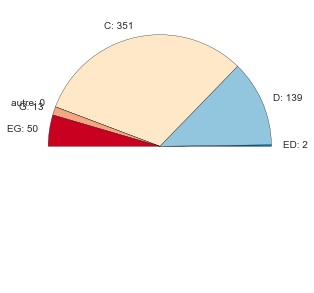

In [80]:
plotsave_results(cm)

In [81]:
#Pour comparaison, la situation historique
def plot_results(rez_d):
    
    #mpl.rcParams['font.size'] = 40.0
    
    ED = rez_d['l_ED']
    D = rez_d['l_D']
    C = rez_d['l_C']
    G = rez_d['l_G']
    EG = rez_d['l_EG']
    autre = rez_d['l_autre']
    
    S = ED + D + C + G + EG + autre
    
    results = [ED/(2 * S), D/(2 * S),
               C/(2 * S), autre/(2 * S),
               G/(2 * S), EG/(2 * S)]
    
    fig = plt.figure(figsize=(5,5), dpi=150)
    plt.pie(results,
            labels=['ED: %d' % ED, 'D: %d' % D, 'C: %d' % C, 'autre: %d' % autre, 'G: %d' % G, 'EG: %d' % EG],
            colors=['#ca0020', '#f4a582', '#b2abd2', '#fee8c8', '#92c5de', '#0571b0'][::-1])
    plt.show()

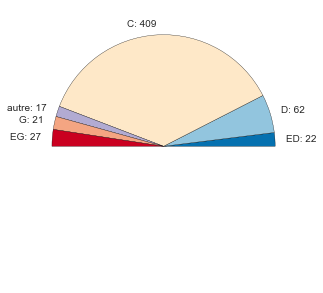

In [82]:
plot_results(real.value_counts())